In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [18]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

features_cols = ['gunning_fog', 'smog_index', 'subjectivity', 'title_text_similarity', 'words_per_sentence',
                 'adv_ratio_title', 'noun_ratio_title', 'words_per_title', 'syllables_per_word',
                 'uppercase_per_title', 'uppercase_ratio_title_text', 'adj_ratio_text', 'adv_ratio_text',
                 'verb_ratio_text', 'noun_ratio_text', 'short_sentences_ratio', 'long_sentences_ratio']

In [19]:
X_train = df_train[features_cols].values
X_val = df_val[features_cols].values
X_test = df_test[features_cols].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
y_train = df_train['label'].tolist()
y_val = df_val['label'].tolist()
y_test = df_test['label'].tolist()

In [21]:
def load_w2v_embedding(idx, folder_path):
    emb = np.load(f"{folder_path}/embedding_{idx}.npy")
    mask = np.load(f"{folder_path}/mask_{idx}.npy")
    return torch.tensor(emb, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [22]:
def create_batch(indices, folder_path, labels, features):
    embeddings, masks, feats, lbls = [], [], [], []
    for idx in indices:
        emb, mask = load_w2v_embedding(idx, folder_path)
        embeddings.append(emb)
        masks.append(mask)
        feats.append(features[idx])
        lbls.append(labels[idx])
    
    embeddings = torch.stack(embeddings).to(device)
    masks = torch.stack(masks).to(device)
    feats = torch.tensor(np.array(feats), dtype=torch.float32).to(device)
    lbls = torch.tensor(lbls).to(device)
    return embeddings, masks, feats, lbls

In [23]:
embedding_dim = 100
hidden_dim = 256
num_classes = 2
num_extra_features = X_train.shape[1]

lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
linear = nn.Sequential(
    nn.Linear(hidden_dim * 2 + num_extra_features, hidden_dim),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(hidden_dim, num_classes)
)

lstm = lstm.to(device)
linear = linear.to(device)

In [24]:
def evaluate_model(lstm, linear, folder_path, labels, features, batch_size=32):
    lstm.eval()
    linear.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for i in range(0, len(labels), batch_size):
            batch_idx = list(range(i, min(i+batch_size, len(labels))))
            embeddings, masks, feats, lbls = create_batch(batch_idx, folder_path, labels, features)

            outputs, _ = lstm(embeddings)
            lengths = masks.sum(dim=1) - 1
            last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
            concat = torch.cat((last_outputs, feats), dim=1)
            logits = linear(concat)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(lbls.cpu())

    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)
    acc = (y_pred == y_true).float().mean().item()
    return y_pred, y_true, acc

In [25]:
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr=1e-4)
num_epochs = 5
batch_size = 32

train_folder = "train_w2v_embeddings"
val_folder = "val_w2v_embeddings"
test_folder = "test_w2v_embeddings"

for epoch in range(num_epochs):
    lstm.train()
    linear.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    indices = list(range(len(y_train)))
    np.random.shuffle(indices)

    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        embeddings, masks, feats, labels = create_batch(batch_indices, train_folder, y_train, X_train)

        optimizer.zero_grad()
        outputs, _ = lstm(embeddings)
        lengths = masks.sum(dim=1) - 1
        last_outputs = outputs[torch.arange(outputs.size(0)), lengths.long()]
        concat = torch.cat((last_outputs, feats), dim=1)
        logits = linear(concat)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    train_acc = (torch.cat(all_preds) == torch.cat(all_labels)).float().mean().item()
    _, _, val_acc = evaluate_model(lstm, linear, val_folder, y_val, X_val, batch_size=batch_size)
    _, _, test_acc = evaluate_model(lstm, linear, test_folder, y_test, X_test, batch_size=batch_size)

    history['train_loss'].append(total_loss / (len(indices) / batch_size))
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {history['train_loss'][-1]:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/5 | Loss: 0.2895 | Train Acc: 0.8725 | Val Acc: 0.9239 | Test Acc: 0.9207
Epoch 2/5 | Loss: 0.1951 | Train Acc: 0.9220 | Val Acc: 0.9371 | Test Acc: 0.9358
Epoch 3/5 | Loss: 0.1635 | Train Acc: 0.9364 | Val Acc: 0.9436 | Test Acc: 0.9441
Epoch 4/5 | Loss: 0.1547 | Train Acc: 0.9410 | Val Acc: 0.9315 | Test Acc: 0.9221
Epoch 5/5 | Loss: 0.1450 | Train Acc: 0.9433 | Val Acc: 0.9411 | Test Acc: 0.9351


In [26]:
pd.DataFrame(history).to_csv("w2v_lstm_features_32_history.csv", index=False)

In [27]:
y_pred, y_true, _ = evaluate_model(lstm, linear, test_folder, y_test, X_test, batch_size=batch_size)

print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, digits=4))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9414    0.9422    0.9418      6883
           1     0.9272    0.9262    0.9267      5471

    accuracy                         0.9351     12354
   macro avg     0.9343    0.9342    0.9342     12354
weighted avg     0.9351    0.9351    0.9351     12354



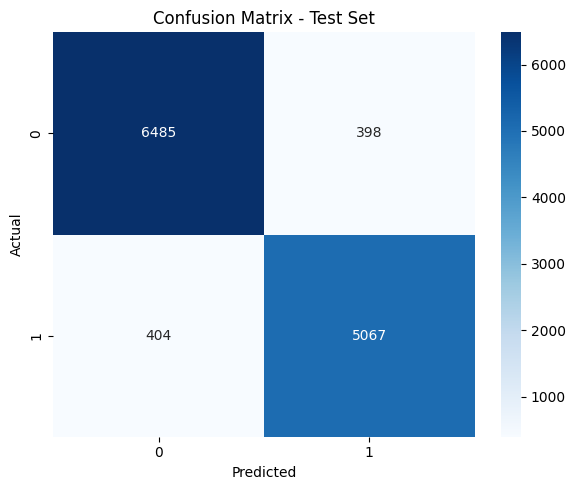

In [28]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()

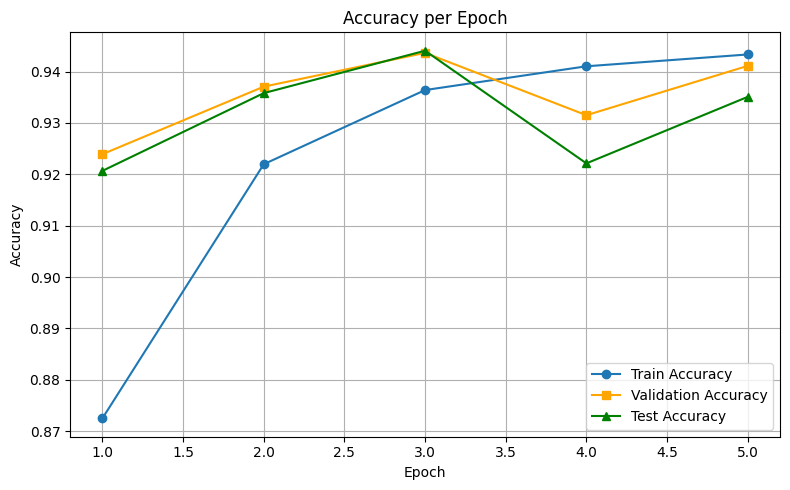

In [29]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='s', color='orange')
plt.plot(epochs, history['test_acc'], label='Test Accuracy', marker='^', color='green')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [30]:
torch.save((lstm, linear), "w2v_lstm_features_32_model_extensie.pt")
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']